In [16]:
from pathlib import Path
import numpy as np
import xarray as xr
import geopandas as gp
import pylab as plt
import pandas as pd
from matplotlib import colors, cm
from matplotlib.colors import LightSource

from pypism import profiles
from pypism.profiles import process_profile
from pypism.utils import preprocess_nc
from pypism.hillshade import hillshade
from pypism.utils import qgis2cmap

In [17]:
profile_resolution = 200 # m

In [18]:
profiles_path = Path("../tests/data/greenland-flux-gates-29_500m.gpkg")
profiles_path = Path("../data/greenland-flux-gates.gpkg")
profiles_gp = gp.read_file(profiles_path).rename(columns={"id": "profile_id"})
geom = profiles_gp.segmentize(profile_resolution)
profiles_gp = gp.GeoDataFrame(profiles_gp, geometry=geom)

In [19]:
obs_file = Path("/Users/andy/Google Drive/My Drive/data/ITS_LIVE/GRE_G0240_0000.nc")
obs_file = Path("/Users/andy/Google Drive/My Drive/data/greenland_rignot_sar/velocity_greenland_v4Aug2014_yx.nc")
obs_ds = xr.open_dataset(obs_file)

In [20]:
pism_files = list(Path("../tests/data").glob("vel*.nc"))
pism_files = list(Path("/Users/andy/Google Drive/My Drive/Projects/gris-calib/data").glob("velsurf_mag_gris*.nc"))

In [21]:
sim_ds = xr.open_mfdataset(pism_files, 
                  preprocess=preprocess_nc,
                  concat_dim="exp_id",
                  combine="nested",
                  parallel=True)

In [22]:
import contextlib
import joblib
from joblib import Parallel, delayed
from tqdm.auto import tqdm

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""

    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        """TQDM Callback"""

        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()


In [23]:
n_jobs = 8
with tqdm_joblib(tqdm(desc="Processing profiles", total=len(profiles_gp))) as progress_bar:
    result = Parallel(n_jobs=n_jobs)(
        delayed(process_profile)(profile, p,
            obs_ds,
            sim_ds
            )
            for p, profile in profiles_gp.iterrows()
        )

Processing profiles:  41%|████████████████████████████████████████████████████████████▊                                                                                         | 73/180 [00:03<00:02, 40.62it/s]/Users/andy/miniconda3/envs/pypism/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/andy/miniconda3/envs/pypism/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Users/andy/miniconda3/envs/pypism/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/Users/andy/miniconda3/envs/pypism/lib/python3.12/site-packages/pypism/profiles.py:112: RuntimeWarning: Mean of empty slice
  rmsd = np.sqrt(np.nanmean((df[col1] - df[col2]) ** 2))
/Users/andy/miniconda3/envs/pypism/lib/python3.12/site-packages

In [32]:
obs_profiles = [r[:][0] for r in result]
sims_profiles = [r[:][1] for r in result]
stats_profiles = pd.concat([r[:][-1] for r in result]).reset_index()
stats_profiles_points = gp.GeoDataFrame(stats_profiles, geometry=stats_profiles.geometry.centroid)

In [25]:
def _compose_alpha(rgb, intensity, opacity):
    """Calculate alpha composition ratio between two images.
    """

    fake_alpha = np.ones_like(intensity)
    comp_alpha = np.minimum(rgb[:, :, 3], fake_alpha) * opacity
    new_alpha = rgb[:, :, 3] + (1.0 - rbg[:, :, 3]) * comp_alpha
    np.seterr(divide='ignore', invalid='ignore')
    ratio = comp_alpha / new_alpha
    ratio[ratio == np.NAN] = 0.0
    return ratio
    
def blend_multiply(rgb, intensity, alpha=0.5):
    """
    Combine an RGB image with an intensity map using "overlay" blending.

    Parameters
    ----------
    rgb : `~numpy.ndarray`
        An (M, N, 3) RGB array of floats ranging from 0 to 1 (color image).
        intensity : `~numpy.ndarray`
        An (M, N, 1) array of floats ranging from 0 to 1 (grayscale image).

    Returns
    -------
    ndarray
        An (M, N, 3) RGB array representing the combined images.
    """
    
    return rgb * alpha  + intensity * (1-alpha)

In [26]:
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)
crs = ccrs.NorthPolarStereo(central_longitude=-45, true_scale_latitude=70, globe=None)


qgis_colormap = Path("../data/speed-colorblind.txt")
cmap = qgis2cmap(qgis_colormap, name="speeds")

# Shade from the northwest, with the sun 45 degrees from horizontal
light_source = LightSource(azdeg=315, altdeg=45)

# sel = .sel(x=slice(-210000, 200000), y=slice(-2100000, -2400000))

jak_extent = {"x": slice(-420000, 60000), "y": slice(-1600000, -2350000)}

gris_target = obs_ds
jak_target = gris_target.sel(**jak_extent)

gris_ds = xr.open_dataset(Path("/Users/andy/Google Drive/My Drive/data/MCdataset/BedMachineGreenland-v5.nc"))
gris_surface = gris_ds["surface"].interp_like(gris_target)
gris_surface_hs = hillshade(gris_surface, zf=5)

#hs = hillshade(gris_dem_ds["surface"], zf=10)
#hs.plot(cmap="Greys_r", vmin=0, vmax=1, add_colorbar=False)

jak_obs_ds = obs_ds.sel(**jak_extent)

jak_speed = jak_obs_ds["v"]
jak_surface = gris_surface.interp_like(jak_target)
jak_hs = hillshade(gris_surface.interp_like(jak_target))


gris_speed = obs_ds["v"]
gris_hs = gris_surface_hs

norm = colors.Normalize(vmin=10.0, vmax=1500.0)
mapper = cm.ScalarMappable(norm=norm, cmap=cmap)

speed_img = mapper.to_rgba(gris_speed)

def get_extent(ds: xr.Dataset):
    return [ds["x"].values[0], ds["x"].values[-1], ds["y"].values[-1], ds["y"].values[0]]

def prepare(v, z, mapper):
    return (mapper.to_rgba(v), z)

extent = get_extent(jak_target)
v, z = prepare(jak_speed.to_numpy(), jak_surface.to_numpy(), mapper)
nx, ny = jak_speed.shape

extent = get_extent(gris_target)
v, z = prepare(gris_speed.to_numpy(), gris_surface.to_numpy(), mapper)
nx, ny = gris_speed.shape


#blended = blend_multiply(rgb[...,:3], jak_hs.to_numpy().reshape(nx, ny, 1))

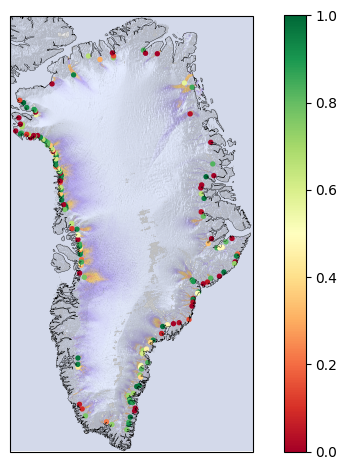

In [33]:
fig = plt.figure()
ax = fig.add_subplot(111, projection=crs)
rgb = light_source.shade_rgb(v, elevation=z, vert_exag=1.0, blend_mode=blend_multiply)
# ax.imshow(jak_hs, cmap='gray', extent=extent, origin="upper", transform=crs)
# ax.imshow(blended, extent=extent, origin="upper", transform=crs)
# ax.imshow(light_source.hillshade(z, vert_exag=1, dx=240, dy=240), cmap='gray', extent=extent, origin="upper", transform=crs)
f = ax.imshow(rgb, extent=extent, origin="upper", transform=crs)
ax.coastlines(linewidth=0.25, resolution="10m")
# ax.gridlines(draw_labels=True, dms=True,x_inline=False, y_inline=False)
# ax.xlocator = mticker.FixedLocator([-55, -50, -45, -40, -35])
# ax.ylocator = mticker.FixedLocator([60, 70, 80])
# ax.xformatter = LongitudeFormatter()
# ax.yformatter = LatitudeFormatter()
stats_profiles_points[stats_profiles_points["exp_id"]=="GRIMP"].plot(column="pearson_r", 
                                                                     vmin=0, vmax=1,
                                                                     cmap="RdYlGn", markersize=8, legend=True, ax=ax)
ax.set_extent(extent, crs=crs)
fig.tight_layout()
fig.savefig("gris_speed.pdf")
#stats_profiles.plot(column="rmsd", cmap="RdYlGn_r", lw=2, ax=ax)

In [34]:
def plot_profile(ds: xr.Dataset):
    fig = ds.profiles.plot(palette="Greens", sigma=1)
    profile_name = ds["profile_name"].to_numpy()
    fig.savefig(f"{profile_name}.pdf")
    plt.close()
    del fig

profiles = [xr.merge([obs_profile.squeeze(), sims_profile.squeeze()]) for obs_profile, sims_profile in zip(obs_profiles, sims_profiles)]
for profile in profiles:
    plot_profile(profile)
# with tqdm_joblib(tqdm(desc="Processing profiles", total=len(profiles_gp))) as progress_bar:
#     result = Parallel(n_jobs=n_jobs)(
#         delayed(plot_profile)(ds)
#             for ds in profiles
#         )

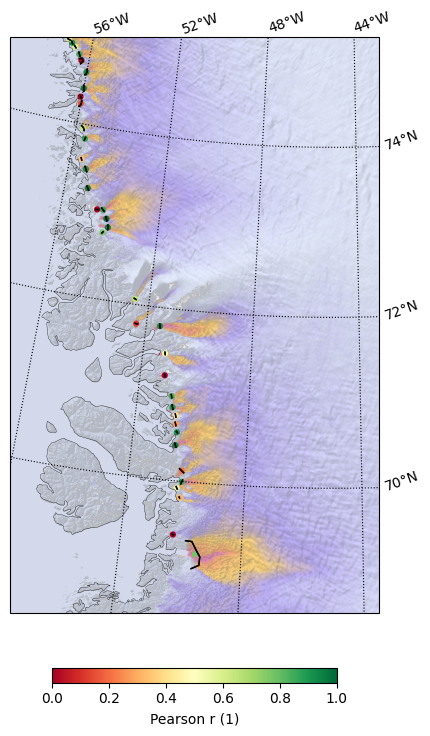

In [35]:
extent = get_extent(jak_target)
v, z = prepare(jak_speed.to_numpy(), jak_surface.to_numpy(), mapper)
nx, ny = jak_speed.shape

fig = plt.figure(figsize=(6, 8))
ax = fig.add_subplot(111, projection=crs)
rgb = light_source.shade_rgb(v, elevation=z, vert_exag=1.0, blend_mode=blend_multiply)
# ax.imshow(jak_hs, cmap='gray', extent=extent, origin="upper", transform=crs)
# ax.imshow(blended, extent=extent, origin="upper", transform=crs)
# ax.imshow(light_source.hillshade(z, vert_exag=1, dx=240, dy=240), cmap='gray', extent=extent, origin="upper", transform=crs)
f = ax.imshow(rgb, extent=extent, origin="upper", transform=crs)
stats_profiles.plot(ax=ax, color="k", lw=1)
stats_profiles_points[stats_profiles_points["exp_id"]=="GRIMP"].plot(column="pearson_r", 
                                                                     vmin=0, vmax=1,
                                                                     cmap="RdYlGn", markersize=12, legend=True, 
                                                                     legend_kwds={"shrink": 0.5, "pad": 0.075,
                                                                                  "location": "bottom", 
                                                                                  "label": "Pearson r (1)"},
                                                                     ax=ax)

ax.coastlines(linewidth=0.25, resolution="10m")
ax.gridlines(draw_labels={"top": "x", "right": "y"}, 
             dms=True,
             xlocs=[-56, -52, -48, -44, -40],
             ylocs=np.arange(56, 88, 2),
             x_inline=False, y_inline=False, 
             rotate_labels=20,
             ls="dotted", color="k")

ax.set_extent(extent, crs=crs)
fig.tight_layout()
fig.savefig("jak_speed.pdf")
